In [1]:
from keras import Input, layers
from keras.models import Model
import tensorflow as tf
import keras.backend as K
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


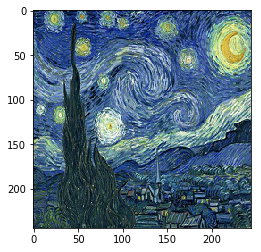

In [2]:
style_img=mpimg.imread('starry_night.jpg')
imgplot = plt.imshow(style_img)
style_img = style_img/255.0

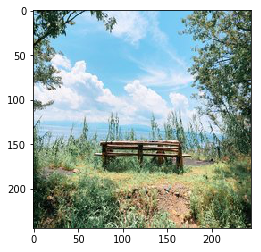

In [3]:
content_img=mpimg.imread('sky.jpeg')
imgplot = plt.imshow(content_img)
content_img = content_img/255.0

In [59]:
K.clear_session()

class AddReconLayer(layers.Layer):
    '''
        white noise가 content reconstruction이 되도록 특정한 값이 더해주는 레이어
    '''

    def __init__(self, **kwargs):
        super(AddReconLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name='kernel',
            shape=input_shape[1:],
            initializer='uniform',
            trainable=True)
        super(AddReconLayer, self).build(input_shape)

    def call(self, x):
        return tf.add(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return input_shape

    
class Recon:
    '''
        Figure 1: Convolution Neurla Network(CNN)의 Style Reconstructions를 재현하기 위한 class
    '''
    
    def __init__(self, style_img, content_img, level, beta=1000.0, show_summary=False):
        
        self.style_img = style_img
        self.content_img = content_img
        self.input_img_size = self.style_img.shape
        self.white_noise = np.random.uniform(size=self.input_img_size)
        
        self.beta = beta
        
        # input
        style_img_input = Input(shape=self.input_img_size, name='style_img')
        content_img_input = Input(shape=self.input_img_size, name='content_img')
        white_noise_input = Input(shape=self.input_img_size, name='white_noise')
        
        self.recon_layer = AddReconLayer()
        rec_img = self.recon_layer(white_noise_input)
        
        # cnn blocks
        x = self._make_cnn_layers(level, (style_img_input, content_img_input, rec_img))
        
        self.model = Model([style_img_input, content_img_input, white_noise_input], x)
        self._set_weights()
        self.output_shape = tuple(x.shape.as_list()[1:])
        
        if show_summary:
            self.model.summary()
        
        self.model.compile(
            optimizer='rmsprop',
            loss='mse',
            metrics=['mse'])        
    
    def _make_cnn_layers(self, level, input_layers):
        
        style_img_input, content_img_input, rec_img = input_layers
        
        # Block classes
        
        # Block 1
        block1_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', trainable=False)
        block1_conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', trainable=False)
        block1_pool = layers.AveragePooling2D((2, 2), strides=(2, 2), name='block1_pool')
        
        # Block 2
        block2_conv1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', trainable=False)
        block2_conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', trainable=False)
        block2_pool = layers.AveragePooling2D((2, 2), strides=(2, 2), name='block2_pool')
        
        # Block 3
        block3_conv1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', trainable=False)
        block3_conv2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', trainable=False)
        block3_conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', trainable=False)
        block3_conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4', trainable=False)
        block3_pool = layers.AveragePooling2D((2, 2), strides=(2, 2), name='block3_pool')
        
        # Block 4
        block4_conv1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', trainable=False)
        block4_conv2 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', trainable=False)
        block4_conv3 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', trainable=False)
        block4_conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4', trainable=False)
        block4_pool = layers.AveragePooling2D((2, 2), strides=(2, 2), name='block4_pool')
        
        # Block 5
        block5_conv1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')
        
        style_loss_list = list()
        content_loss = None
        
        if level >= 1:
            # style loss
            f, p = block1_conv1(style_img_input), block1_conv1(rec_img)
            style_loss_list.append(self._make_style_loss(f, p, 1))
            
            # content loss
            c = block1_conv1(content_img_input)

            if level == 1:
                 content_loss = self._make_content_loss(c, p)
            
        if level >= 2:
            # style loss
            f, p = block1_conv2(f), block1_conv2(p)
            f, p = block1_pool(f), block1_pool(p)
            
            f, p = block2_conv1(f), block2_conv1(p)
            style_loss_list.append(self._make_style_loss(f, p, 2))
            
            # content loss
            c = block1_conv2(c)
            c = block1_pool(c)
            c = block2_conv1(c)
            
            if level == 2:
                content_loss = self._make_content_loss(c, p)
            
        if level >= 3:
            # style loss
            f, p = block2_conv2(f), block2_conv2(p)
            f, p = block2_pool(f), block2_pool(p)
            
            f, p = block3_conv1(f), block3_conv1(p)
            style_loss_list.append(self._make_style_loss(f, p, 3))
            
            # content loss
            c = block2_conv2(c)
            c = block2_pool(c)
            c = block3_conv1(c)
            
            if level == 3:
                content_loss = self._make_content_loss(c, p)            
        
        if level >= 4:
            f, p = block3_conv2(f), block3_conv2(p)
            f, p = block3_conv3(f), block3_conv3(p)
            f, p = block3_conv4(f), block3_conv4(p)
            f, p = block3_pool(f), block3_pool(p)

            f, p = block4_conv1(f), block4_conv1(p)
            style_loss_list.append(self._make_style_loss(f, p, 4))
            
            if level == 4:
                content_loss = self._make_content_loss(f, p)            
        
        if level == 5:
            f, p = block4_conv2(f), block4_conv2(p)
            f, p = block4_conv3(f), block4_conv3(p)
            f, p = block4_conv4(f), block4_conv4(p)
            f, p = block4_pool(f), block4_pool(p)

            f, p = block5_conv1(f), block5_conv1(p)
            style_loss_list.append(self._make_style_loss(f, p, 5))
            
            if level == 5:
                content_loss = self._make_content_loss(f, p)        
        
        k = layers.Lambda(lambda x: x*self.beta)
        
        if level == 1:
            return layers.Add()([k(style_loss_list[0]), content_loss])
        else:
            return layers.Add()([k(layers.Add()(style_loss_list)), content_loss])
    
    @staticmethod
    def _make_content_loss(f, p):
        x = layers.Subtract(name='content_loss_subtract')([f, p])
        x = layers.Lambda(lambda x: tf.square(x), name='content_loss_sqaure')(x)
        x = layers.Lambda(lambda x: tf.reduce_mean(x, keepdims=True), output_shape=(1,1), name='content_loss_sum')(x)
        
        return x
        
    @staticmethod
    def _make_style_loss(f, p, l):
        # 기타 필요한 custom layer
        outer_product = layers.Lambda(lambda x: tf.matmul(layers.Permute((2, 1))(x), x), name=f'outer_product_{l}')
        square = layers.Lambda(lambda x: tf.square(x), name=f'sqaure_{l}')
        reduce_sum = layers.Lambda(lambda x: K.sum(x, keepdims=True), output_shape=(1,1), name=f'reduce_sum_{l}')
        
        oh, ow, nl = f.shape.as_list()[1:]

        gf = layers.Reshape((oh*ow, nl))(f)
        gf = outer_product(gf)

        gp = layers.Reshape((oh*ow, nl))(p)
        gp = outer_product(gp)

        x = layers.Subtract()([gf, gp])
        x = layers.Lambda(lambda x: tf.divide(x, 2.0*oh*ow*nl))(x)
        x = square(x)
        x = reduce_sum(x)
        
        return x
        
    def _set_weights(self):
        with h5py.File('vgg19_weights_tf_dim_ordering_tf_kernels.h5', 'r') as f:
            for l in self.model.layers:
                if l.name in list(f.keys()) and 'conv' in l.name:
                    w, b = list(f[l.name])
                    w, b = f[l.name][w][:], f[l.name][b][:]
                    l.set_weights([w, b])
    
    def fit(self, epoch=500):
        for i in range(epoch):
            verbose = 0
            if i % 100 == 0:
                print(i)
                verbose = 2
            
            self.model.fit(
                {
                    'style_img': np.asarray([self.style_img]), 
                    'content_img': np.asarray([self.content_img]),
                    'white_noise': np.asarray([self.white_noise])},
                np.zeros((1,1,1), dtype='float32'),
                epochs=1,
                batch_size=1,
                verbose=verbose)
    
    def show_img(self):
        rec_img = np.ceil((self.white_noise + K.eval(self.recon_layer.kernel))*255).astype('int')
        plt.imshow(rec_img)

In [68]:
con = Recon(style_img, content_img, level=3, beta=50.0, show_summary=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
white_noise (InputLayer)        (None, 244, 244, 3)  0                                            
__________________________________________________________________________________________________
style_img (InputLayer)          (None, 244, 244, 3)  0                                            
__________________________________________________________________________________________________
add_recon_layer_3 (AddReconLaye (None, 244, 244, 3)  178608      white_noise[0][0]                
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 244, 244, 64) 1792        style_img[0][0]                  
                                                                 add_recon_layer_3[0][0]          
          

In [71]:
con.fit()

0
Epoch 1/1
 - 1s - loss: 1.2102 - mean_squared_error: 1.2102
100
Epoch 1/1
 - 2s - loss: 0.8686 - mean_squared_error: 0.8686
200
Epoch 1/1
 - 1s - loss: 0.7196 - mean_squared_error: 0.7196
300
Epoch 1/1
 - 1s - loss: 0.6449 - mean_squared_error: 0.6449
400
Epoch 1/1
 - 1s - loss: 0.6012 - mean_squared_error: 0.6012


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


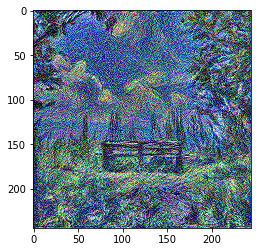

In [72]:
con.show_img()